Checking whether dark dresses could be observed at earth-based interferometers.

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import pickle
from typing import Callable, Dict, Tuple

import dynesty
from dynesty import plotting as dyplot
import jax
import jax.numpy as jnp
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar
from tqdm.auto import tqdm

from pydd.analysis import *
from pydd.binary import *
from pydd.noise import *

rho_s_pbh = 1.798e4 * MSUN / PC ** 3
gamma_s_pbh = 9 / 4

In [5]:
def get_fl_ttoh(m_1, m_2, rho_6, gamma_s, f_range, t_to_h_max):
    _dd = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=100e6 * PC)  # dL irrelevant
    f_h = min(_dd.f_c, f_range[1])
    get_t_to_h = lambda f_l: t_to_c(f_l, _dd) - t_to_c(f_h, _dd)
    res = minimize_scalar(
        lambda f_l: (get_t_to_h(f_l) - t_to_h_max) ** 2,
        bounds=(f_range[0], 0.999 * f_h),
        method="bounded",
    )
    assert res.success, res
    f_l = res.x
    t_to_h = get_t_to_h(f_l)
    return f_l, t_to_h


def get_dL(m_1, m_2, rho_6, gamma_s, S_n, f_l, f_h, snr_thresh):
    fs_snr = jnp.linspace(f_l, f_h, 1000)

    def fun(x):
        dd = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=x)
        return calculate_SNR(dd, fs_snr, S_n) - snr_thresh

    res = root_scalar(fun, bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    return res.root

In [33]:
S_n, f_range = S_n_aLIGO, f_range_aLIGO
m_1 = 1 * MSUN
m_2 = 10 ** -3 * MSUN
rho_s = rho_s_pbh
gamma_s = gamma_s_pbh
rho_6 = get_rho_6(rho_s, m_1, gamma_s)

# Get f_l and dL
snr_thresh = 12.0
t_to_h_max = 1 * YR
f_l, t_to_h = get_fl_ttoh(m_1, m_2, rho_6, gamma_s, f_range, t_to_h_max)
f_h = min(get_f_isco(m_1), f_range[1])
dL = get_dL(m_1, m_2, rho_6, gamma_s, S_n, f_l, f_h, snr_thresh)

# Set up system
dd_s = make_dynamic_dress(m_1, m_2, rho_6, gamma_s, dL=dL)
fs = jnp.linspace(f_l, f_h, 100000)
pad_low, pad_high = get_match_pads(fs)

In [41]:
base_path = f"m1={(m_1 / MSUN):g}_m2={(m_2 / MSUN):g}"

# Parameter ranges
M_chirp_MSUN_range = (
    dd_s.M_chirp / MSUN * (1 - 1e-6),
    dd_s.M_chirp / MSUN * (1 + 1e-6),
)
log10_q_range = (-3.25, -2.75)


def ptform(u):
    M_chirp_MSUN = (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * u[
        0
    ] + M_chirp_MSUN_range[0]
    log10_q = (log10_q_range[1] - log10_q_range[0]) * u[1] + log10_q_range[0]
    return jnp.array([M_chirp_MSUN, log10_q])


def get_loglikelihood_fn(dd_s, rho_s, gamma_s, fs, pad_low, pad_high, S_n):
    """
    x: parameter point
    dd_s: signal system
    """
    def _ll(x):
        # Unpack parameters into dark dress ones
        M_chirp_MSUN, log10_q = x
        M_chirp = M_chirp_MSUN * MSUN
        q = 10 ** log10_q
        m_1 = get_m_1(M_chirp, q)
        m_2 = get_m_2(M_chirp, q)
        rho_6 = get_rho_6(rho_s, m_1, gamma_s)
        f_c = get_f_isco(m_1)

        dd_h = DynamicDress(
            gamma_s_pbh, rho_6, M_chirp, q, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, f_c
        )

        return loglikelihood_fft(dd_h, dd_s, fs, pad_low, pad_high, S_n)
    
    return _ll

Run `dynesty` for dark dress

In [42]:
loglikelihood = jax.jit(
    get_loglikelihood_fn(dd_s, rho_s, gamma_s, fs, pad_low, pad_high, S_n)
)

# Run
sampler = dynesty.NestedSampler(loglikelihood, ptform, 2, nlive=500)
sampler.run_nested()
results = sampler.results

5222it [42:26,  2.05it/s, +500 | bound: 11 | nc: 1 | ncall: 25318 | eff(%): 22.601 | loglstar:   -inf < 72.090 <    inf | logz: 62.447 +/-  0.190 | dlogz:  0.001 >  0.509]


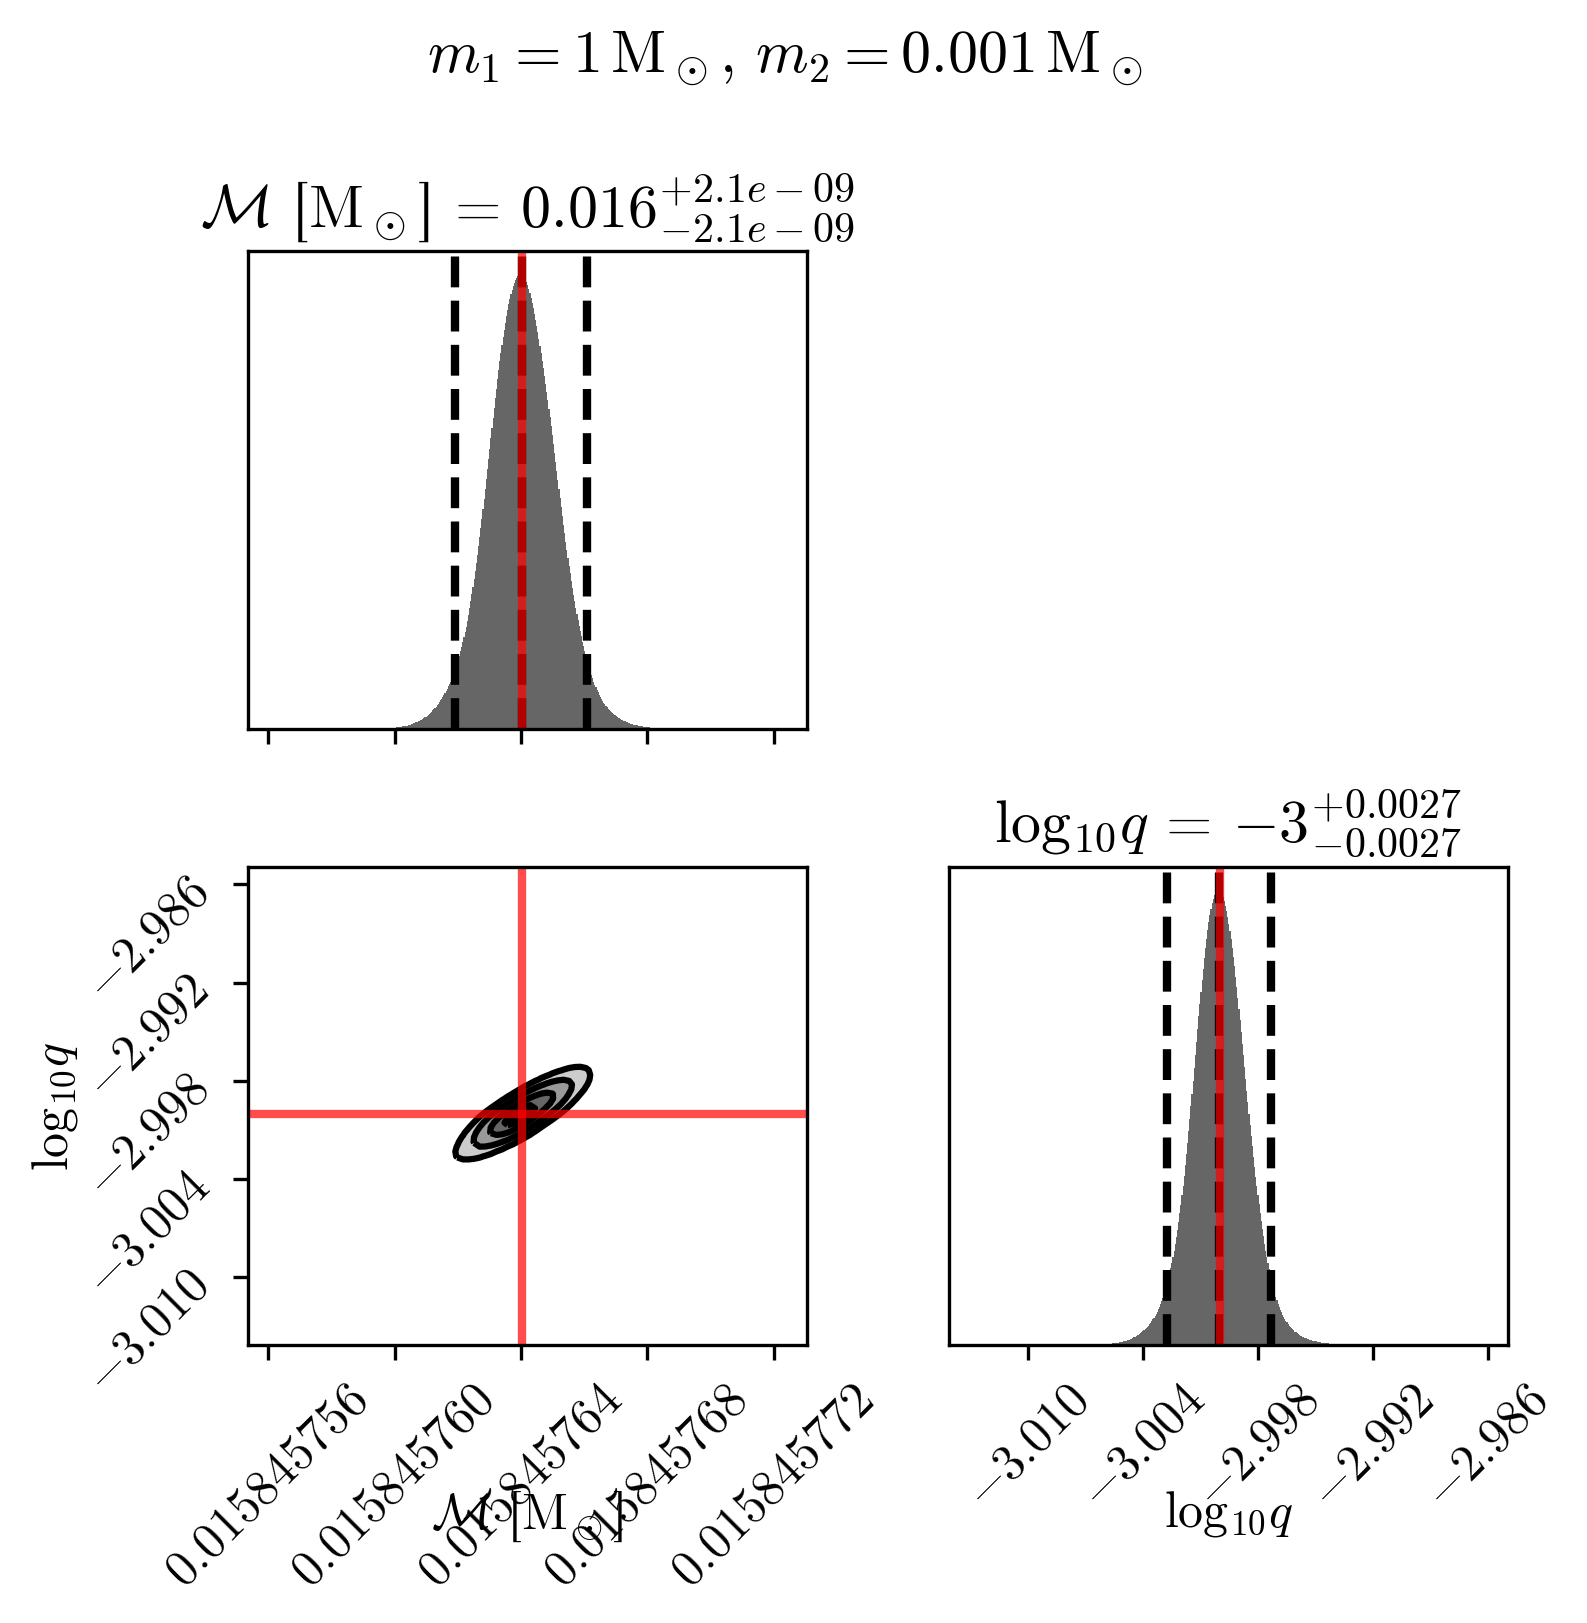

In [43]:
# Plot
M_chirp = get_M_chirp(m_1, m_2)
log10_q = jnp.log10(m_2 / m_1)

labels = (r"$\mathcal{M}$ [M$_\odot$]", r"$\log_{10} q$")
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
smooth = 0.01
cfig = dyplot.cornerplot(
    results,
    labels=labels,
    #     quantiles_2d=quantiles_2d,
    #     smooth=smooth,
    truths=(M_chirp / MSUN, log10_q),
#     span=(1, 1),
    show_titles=True,
    title_fmt=".2g"
)[0]
cfig.suptitle(
    r"$m_1 = %g\, \mathrm{M}_\odot, \, m_2 = %g\, \mathrm{M}_\odot$"
    % (m_1 / MSUN, m_2 / MSUN)
)
cfig.tight_layout()
cfig.savefig(f"figures/post_aLIGO_m1={(m_1 / MSUN):g}Msun.pdf")

# Save
with open(f"ns/{base_path}.pkl", "wb") as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

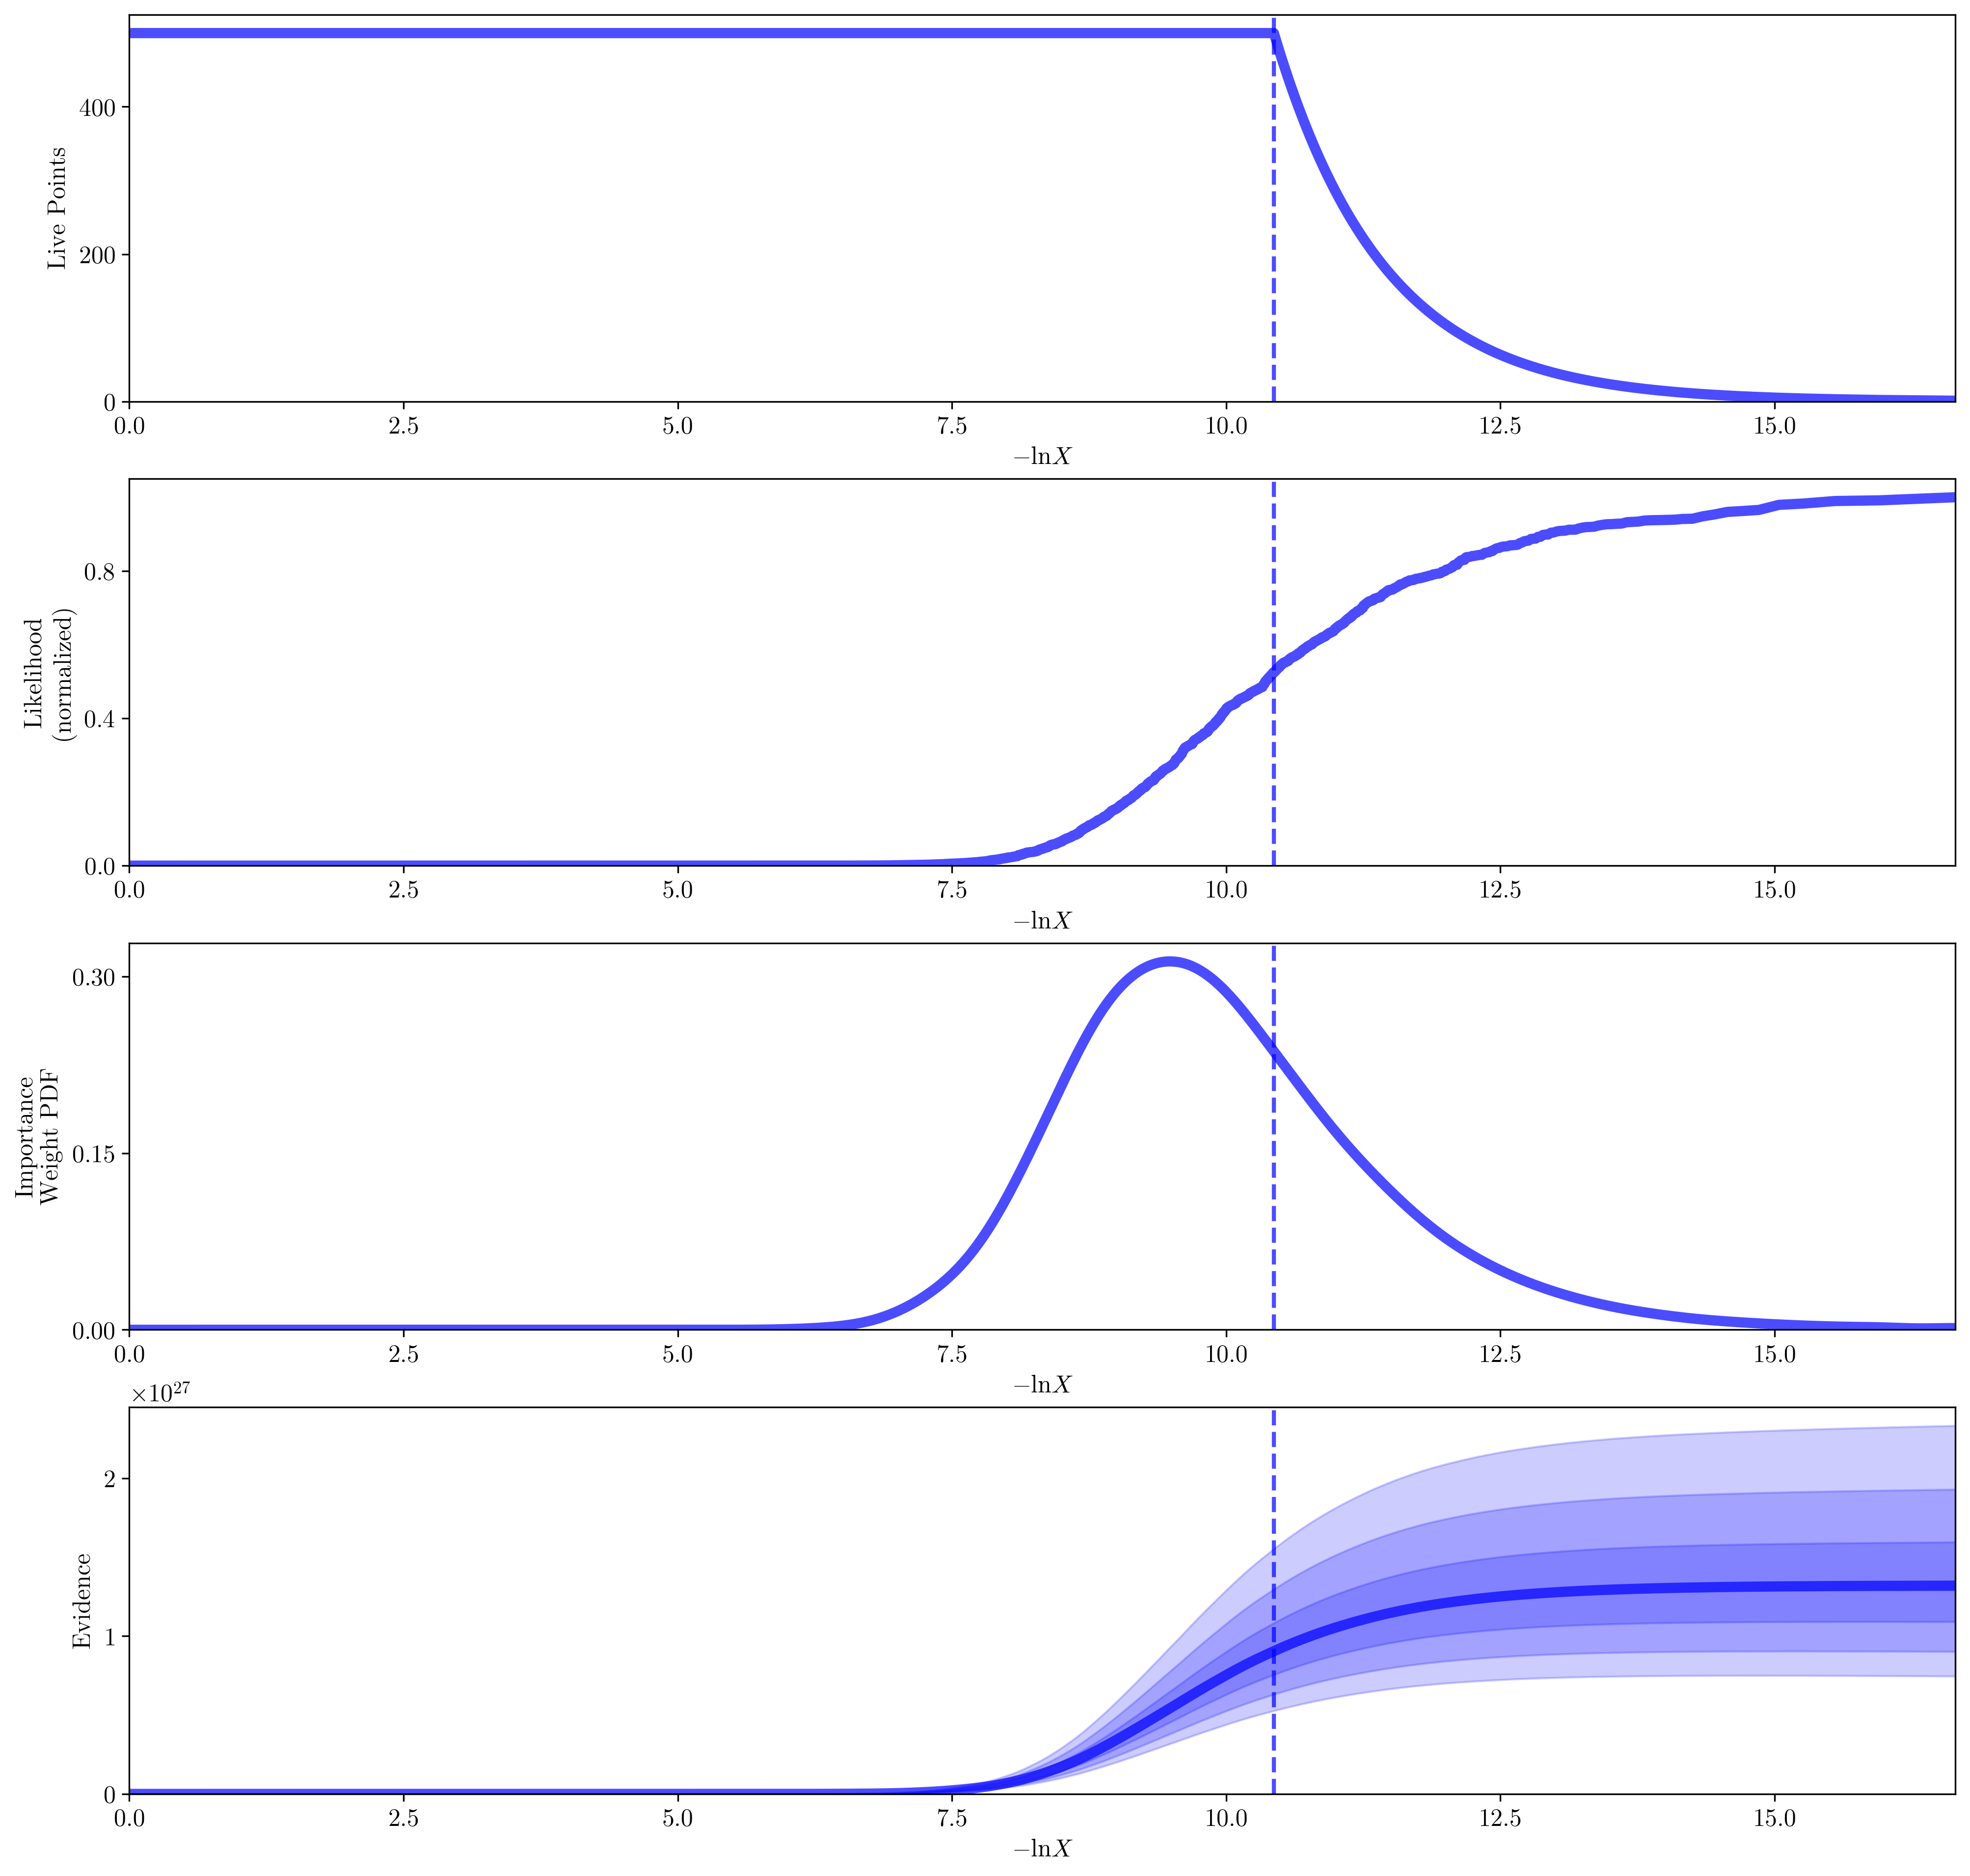

In [44]:
dyplot.runplot(results);

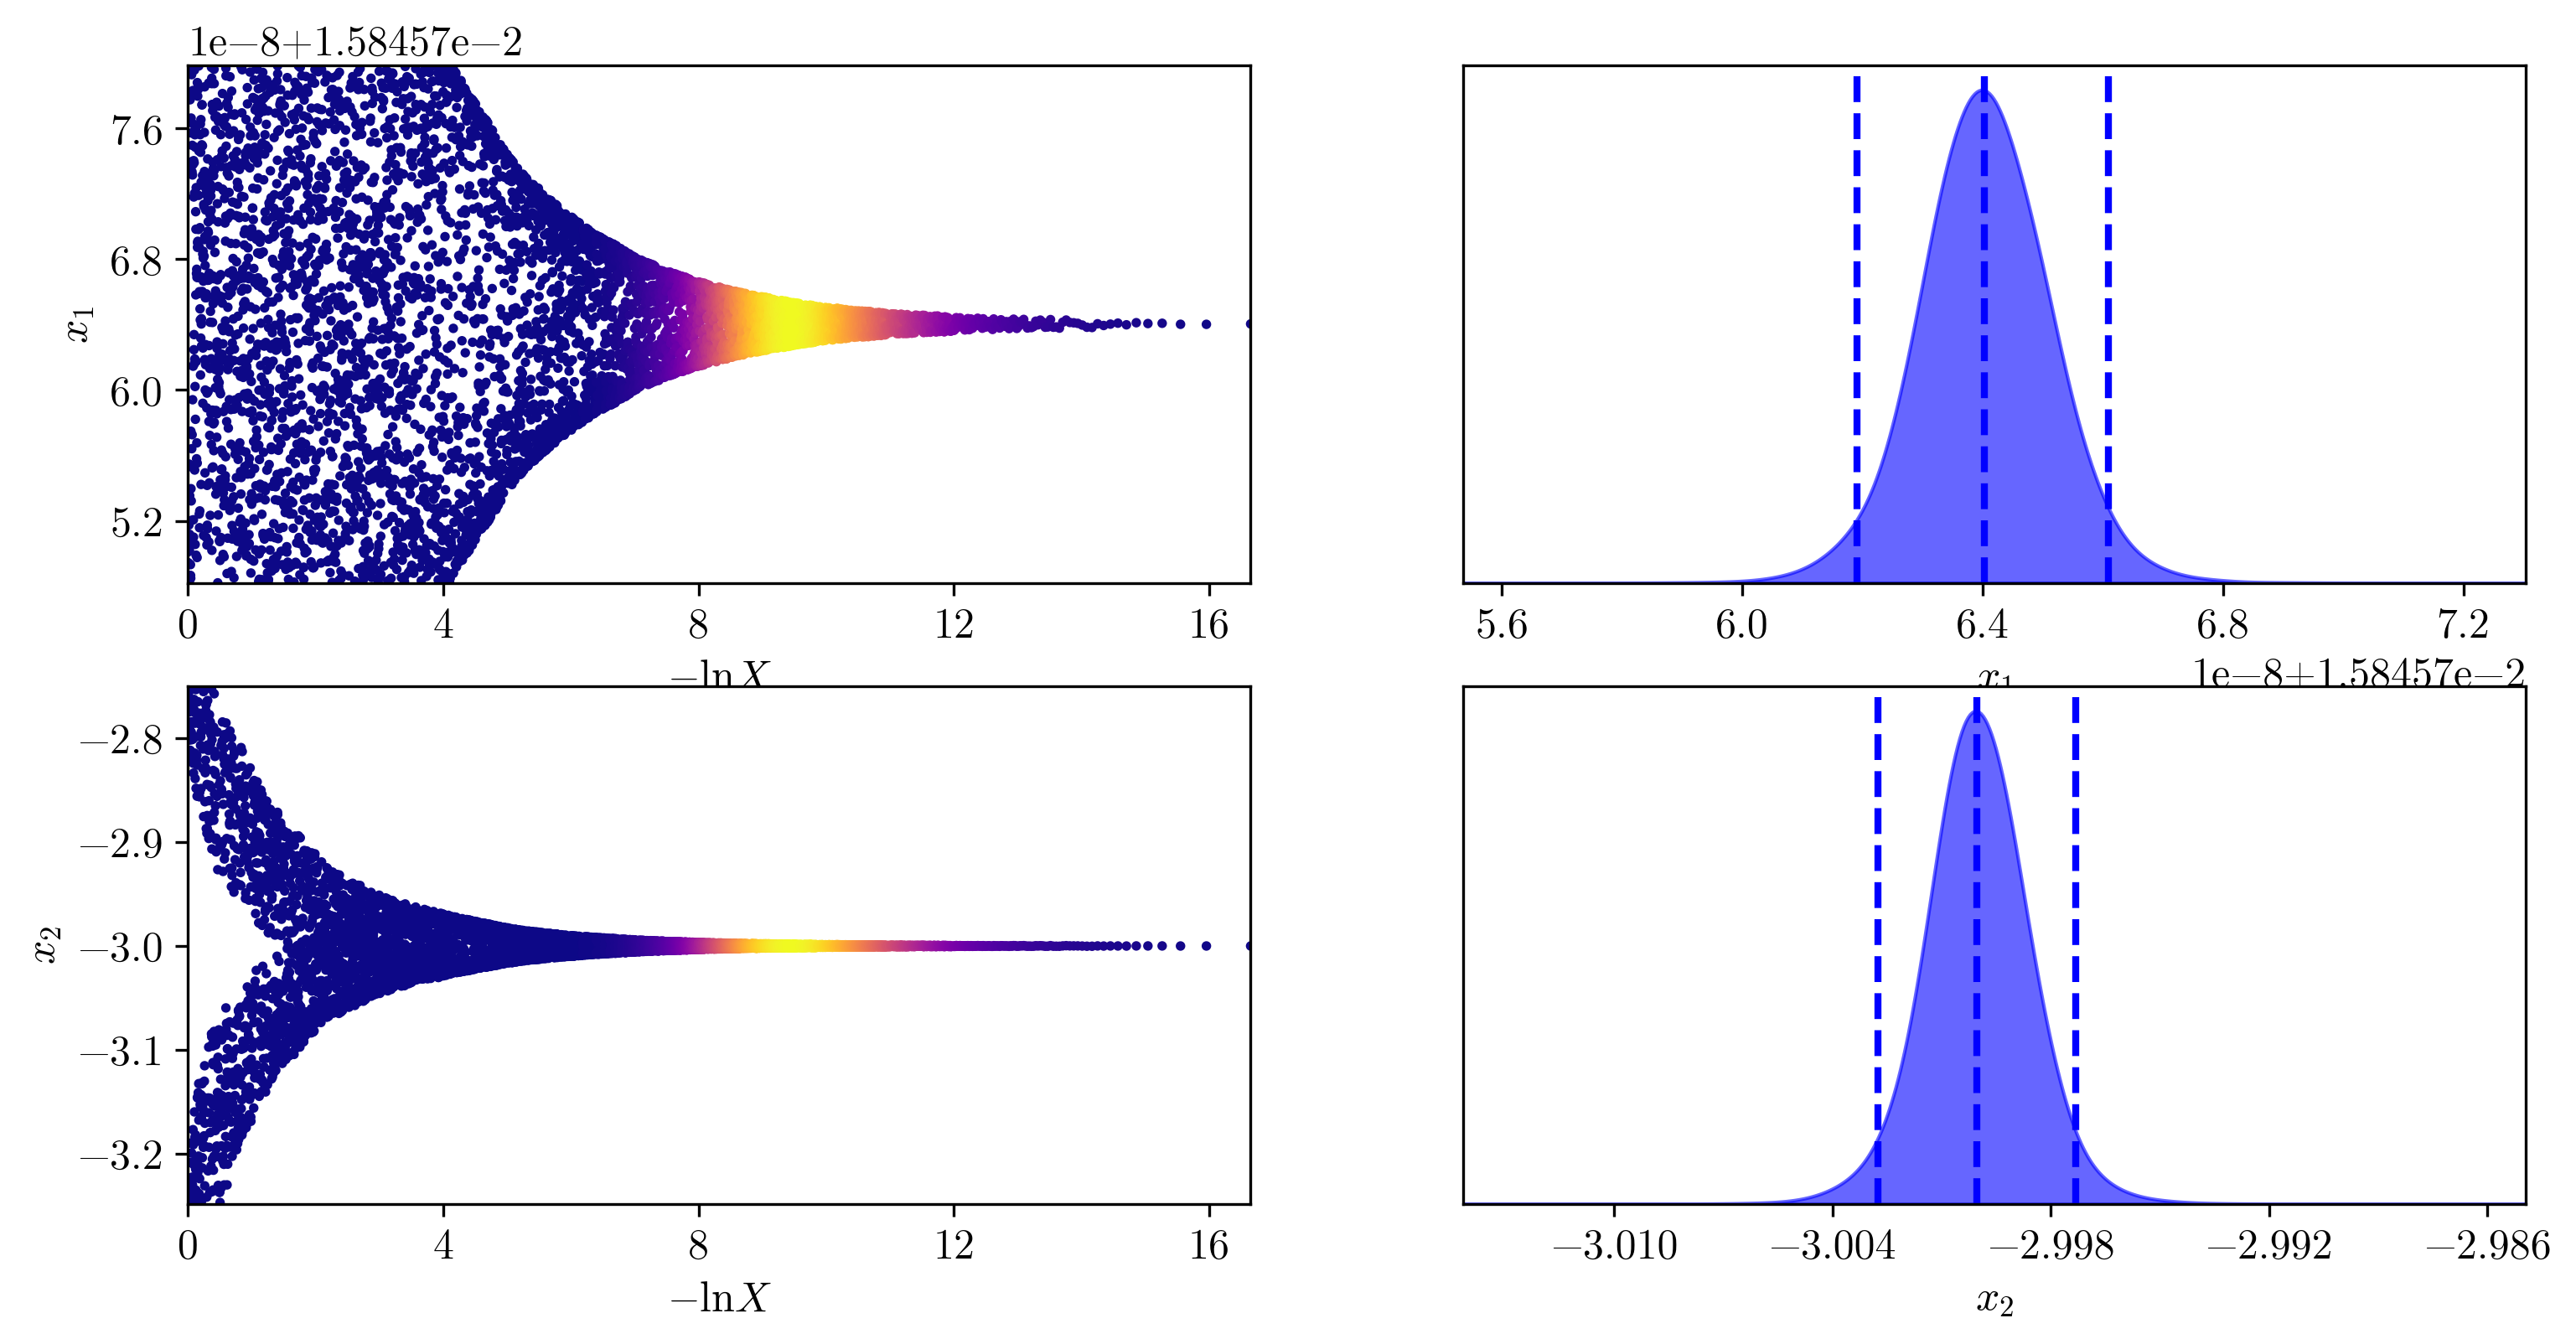

In [45]:
dyplot.traceplot(results);

Run `dynesty` for vacuum system. NOT UPDATED YET!

In [63]:
# M_chirp_MSUN_range_v = (dd_s.M_chirp / MSUN, dd_s.M_chirp / MSUN * (1 + 3e-5))
M_chirp_MSUN_range_v = (0.07922925, 0.07923025)


def ptform_v(u):
    M_chirp_MSUN = (M_chirp_MSUN_range_v[1] - M_chirp_MSUN_range_v[0]) * u[
        0
    ] + M_chirp_MSUN_range_v[0]
    return jnp.array(M_chirp_MSUN)


def get_loglikelihood_v(x, dd_s, f_l, f_h, S_n):
    """
    x: parameter point
    dd_s: signal system
    """
    # Unpack parameters into dark dress ones
    M_chirp_MSUN = x
    M_chirp = M_chirp_MSUN * MSUN
    vb_h = VacuumBinary(M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, dd_s.f_c)

    return loglikelihood_fft(vb_h, dd_s, f_l, f_h, 100000, 3000, S_n)

In [64]:
loglikelihood_v = lambda x: get_loglikelihood_v(x, dd_s, f_l, f_h, S_n)

# Run
sampler_v = dynesty.NestedSampler(loglikelihood_v, ptform_v, 1, nlive=500)
sampler_v.run_nested()
results_v = sampler_v.results

1504it [06:05,  4.11it/s, +500 | bound: 0 | nc: 1 | ncall: 10115 | eff(%): 19.812 | loglstar:   -inf < 43.797 <    inf | logz: 41.693 +/-  0.056 | dlogz:  0.001 >  0.509]


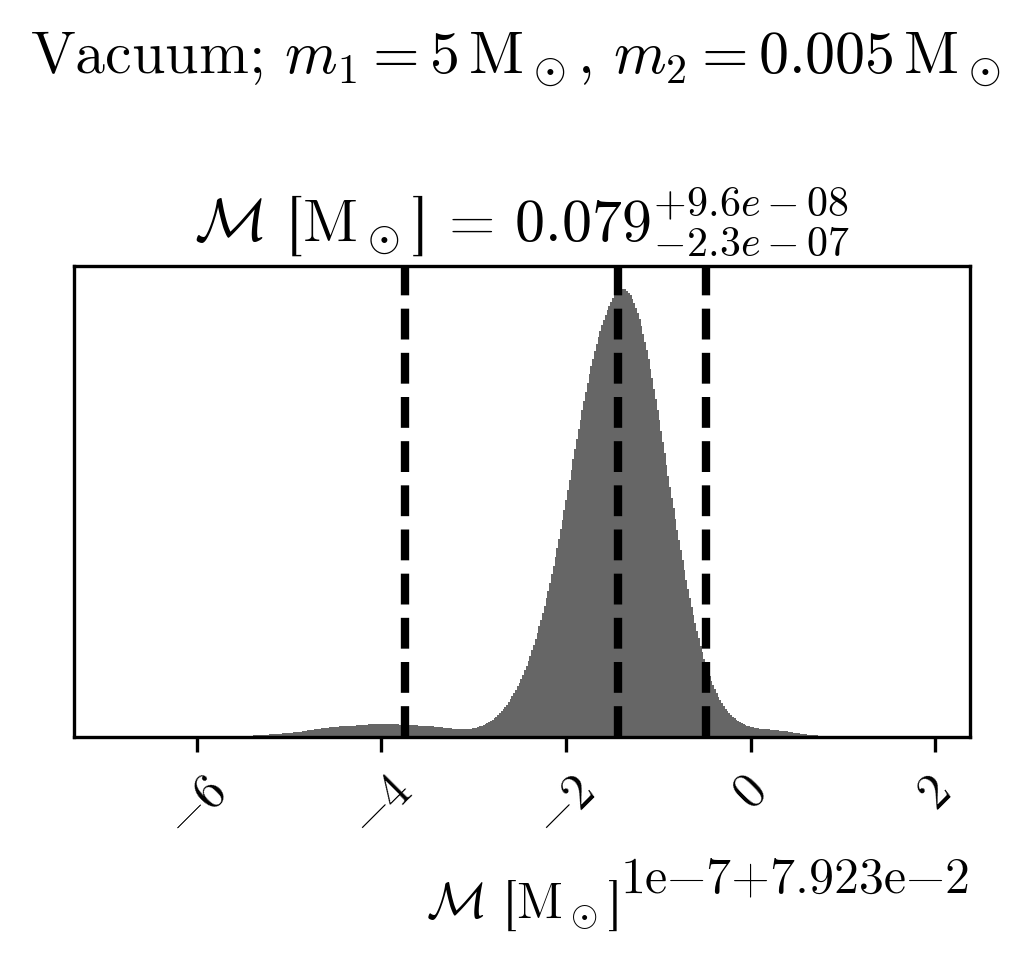

In [67]:
# Save
with open(f"ns/{base_path}_v.pkl", "wb") as output:
    pickle.dump(results_v, output, pickle.HIGHEST_PROTOCOL)

# Plot
M_chirp_MSUN_true = get_M_chirp(m_1_MSUN_true, m_2_MSUN_true)
labels_v = (r"$\mathcal{M}$ [M$_\odot$]",)
cfig = dyplot.cornerplot(
    results_v,
    labels=labels_v,
    truths=(M_chirp_MSUN_true,),
#     span=(1,),
    show_titles=True,
    title_fmt=".2g"
)[0]
cfig.suptitle(
    r"Vacuum; $m_1 = %g\, \mathrm{M}_\odot, \, m_2 = %g\, \mathrm{M}_\odot$"
    % (m_1_MSUN_true, m_2_MSUN_true)
)
cfig.tight_layout()
cfig.savefig(f"figures/corner_dynesty_2d_aLIGO_m1={m_1_MSUN_true:g}Msun_v.pdf")

Bayes factor

In [115]:
z = jnp.exp(results["logz"][-1]) * (M_chirp_MSUN_range[1] - M_chirp_MSUN_range[0]) * (log10_q_range[1] - log10_q_range[0]) / (-2.5 + 4)
z_v = jnp.exp(results_v["logz"][-1]) * (M_chirp_MSUN_range_v[1] - M_chirp_MSUN_range_v[0])
print(f"Bayes factor: {z / z_v:g}")

Bayes factor: 2.27888e+09


Fiddling: compute posterior over a grid

In [126]:
M_chirp_MSUN_g = jnp.linspace(*M_chirp_MSUN_range, 12)
log10_q_g = jnp.linspace(*log10_q_range, 10)
M_chirp_MSUN_mg, log10_q_mg = jnp.meshgrid(M_chirp_MSUN_g, log10_q_g)
lls = jnp.vectorize(lambda a, b: loglikelihood(jnp.array([a, b])))(
    M_chirp_MSUN_mg, log10_q_mg
)

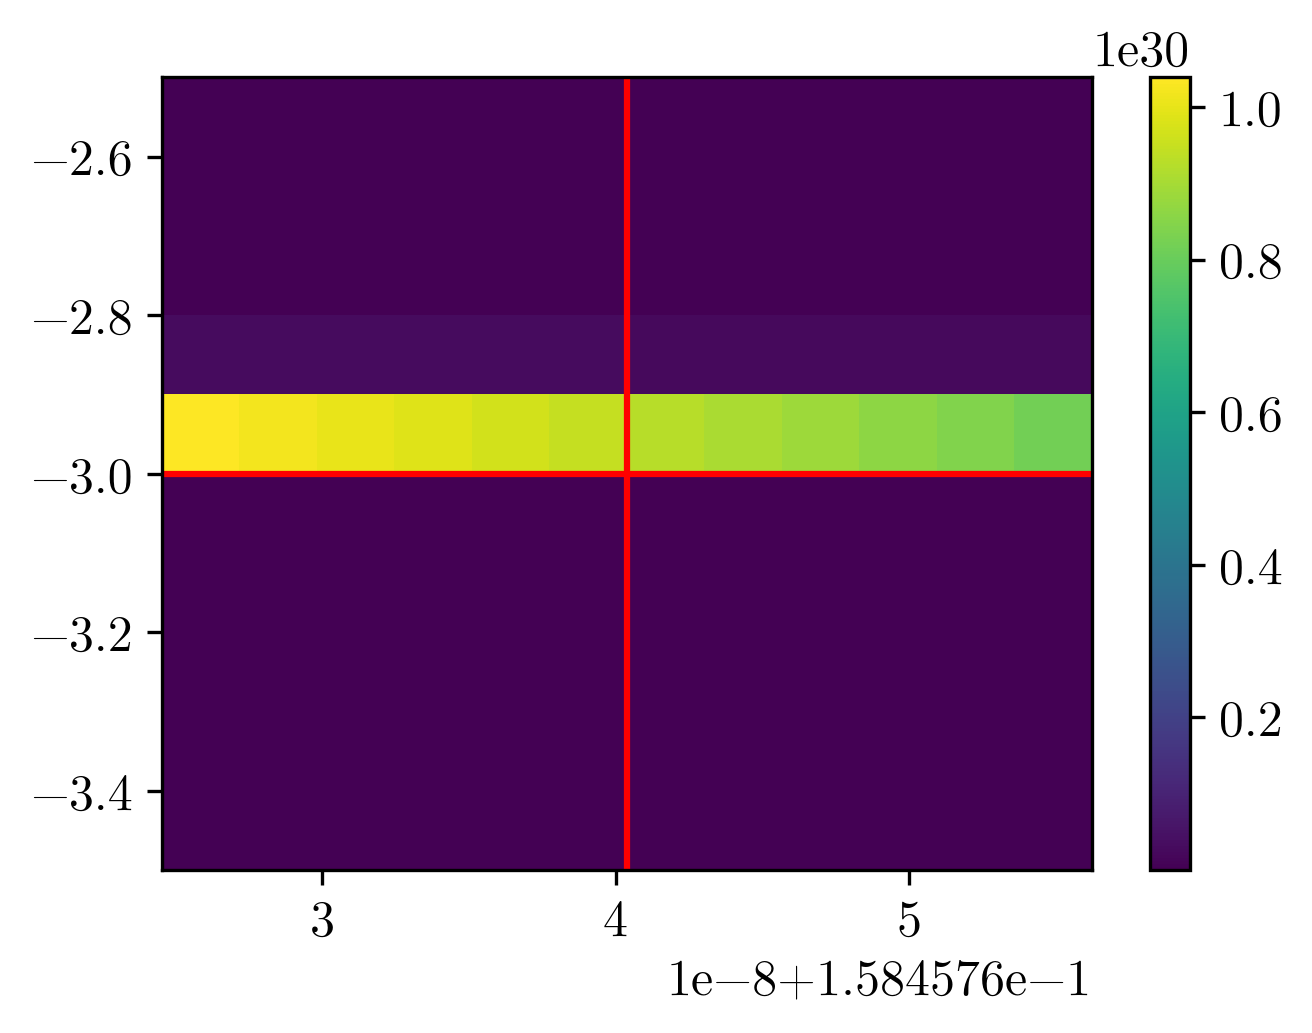

In [127]:
plt.imshow(jnp.exp(lls), extent=(*M_chirp_MSUN_range, *log10_q_range), aspect="auto")
plt.colorbar()
plt.axvline(M_chirp_MSUN_true, color="r")
plt.axhline(log10_q_true, color="r")

# From other notebook

In [198]:
def get_statistics(
    m_1: float,
    m_2: float,
    S_n: Callable[[jnp.ndarray], jnp.ndarray],
    f_range: Tuple[float, float],
    rho_s: float = rho_s_pbh,
    gamma_s: float = gamma_s_pbh,
    snr_thresh: float = 12,
) -> Dict[str, jnp.ndarray]:
    """
    Computes statistcs for dark dresses around PBHs.
    
    Arguments
    - m_1, m_2: black hole masses [kg]
    - S_n: noise PSD
    - f_range: support of S_n
    - rho_s, gamma_s: initial spike parameters. Default to PBH ones.
    - snr_thresh: target SNR. Used to compute distance to binary.
    
    Returns
    A dict with the following quantities:
    - dL: distance such that the system has the target SNR.
    - f_h: the smaller of max(f_range) and the binary's chirp frequency.
    - t_to_h: the time the system spends in band/before merging.
    - N_to_h: the number of GW cycles while the system is in band/before merging
    - snr: system's SNR. This is redundant, since it's just `snr_thresh`.
    - dN_naive: dephasing between system with and without dress between
      `f_range[0]` and `f_h`.
    - dN: dephasing between dark dress and best-fit vacuum system between
      `f_range[0]` and `f_h`.
    - M_chirp_MSUN: dark dress' chirp mass [MSUN].
    - M_chirp_MSUN_v: best-fit vacuum binary's chirp mass [MSUN].
    - snr_loss_frac: fraction of SNR lost by using vacuum template to search
      for the dark dress.
    """
    result = defaultdict(lambda: jnp.nan)
    if m_2 / m_1 > 10 ** (-2.5):
        return result

    f_l = f_range[0]

    # Find dL giving the correct SNR
    def fun(x):
        dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s, dL=x)
        f_h = min(dd.f_c, f_range[1])
        return calculate_SNR(dd, f_l, f_h, 1000, S_n) - snr_thresh

    res = root_scalar(fun, bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    result["dL"] = res.root

    dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s, dL=result["dL"])
    f_h = min(dd.f_c, f_range[1])
    vb_0 = convert(dd, VacuumBinary)

    # Basic information
    result["f_h"] = f_h
    result["t_to_h"] = t_to_c(f_l, dd) - t_to_c(f_h, dd)
    result["N_to_h"] = (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)) / (2 * pi)
    result["snr"] = calculate_SNR(dd, f_l, f_h, 1000, S_n)
    result["dN_naive"] = (
        Phi_to_c(f_l, vb_0)
        - Phi_to_c(f_h, vb_0)
        - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    # Get best-fit vacuum system
    def fun(x):
        vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
        nll = -loglikelihood_fft(vb, dd, f_l, f_h, 10000, 1000, S_n)
        return nll

    bracket = (dd.M_chirp / MSUN, dd.M_chirp / MSUN * (1 + 5e-3))
    res = minimize_scalar(fun, bracket=bracket, tol=1e-100)
    assert res.success
    #     assert bracket[0] < res.x and bracket[1] > res.x
    vb = VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)

    result["M_chirp_MSUN"] = dd.M_chirp / MSUN
    result["M_chirp_MSUN_v"] = res.x
    match = calculate_match_unnormd_fft(vb, dd, f_l, f_h, 10000, S_n)
    result["snr_loss_frac"] = jnp.clip(
        (result["snr"] - jnp.sqrt(match)) / result["snr"], 0
    )
    result["dN"] = (
        Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd))
    ) / (2 * pi)

    return result

In [238]:
# Run analysis
m_1_g = jnp.geomspace(1 * MSUN, 100 * MSUN, 40)
m_2_g = jnp.geomspace(1e-3 * MSUN, 5e-1 * MSUN, 38)
m_1_mg, m_2_mg = jnp.meshgrid(m_1_g, m_2_g)
m_1s, m_2s = m_1_mg.flatten(), m_2_mg.flatten()

results = []
for (m_1, m_2) in tqdm(list(zip(m_1s, m_2s))):
    results.append(get_statistics(m_1, m_2, S_n_et, f_range_et))

results = {
    k: jnp.array([r[k] for r in results]).reshape((len(m_2_g), len(m_1_g)))
    for k in results[0]
}

  0%|          | 0/1520 [00:00<?, ?it/s]

In [239]:
# jnp.savez("outputs/et.npz", m_1_mg=m_1_mg, m_2_mg=m_2_mg, **results)

Plot the results! Change the cell below as well as the contour levels to whatever you want.

In [67]:
# Load
results = {k: jnp.array(v) for k, v in dict(jnp.load("outputs/et.npz")).items()}
m_1_g = results.pop("m_1_mg")[0]
m_2_g = results.pop("m_2_mg")[:, 0]
m_1_mg, m_2_mg = jnp.meshgrid(m_1_g, m_2_g)
title = "Einstein Telescope"
plot_name = "figures/et.pdf"

<ipython-input-245-3f20b65fbe96>:14: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(


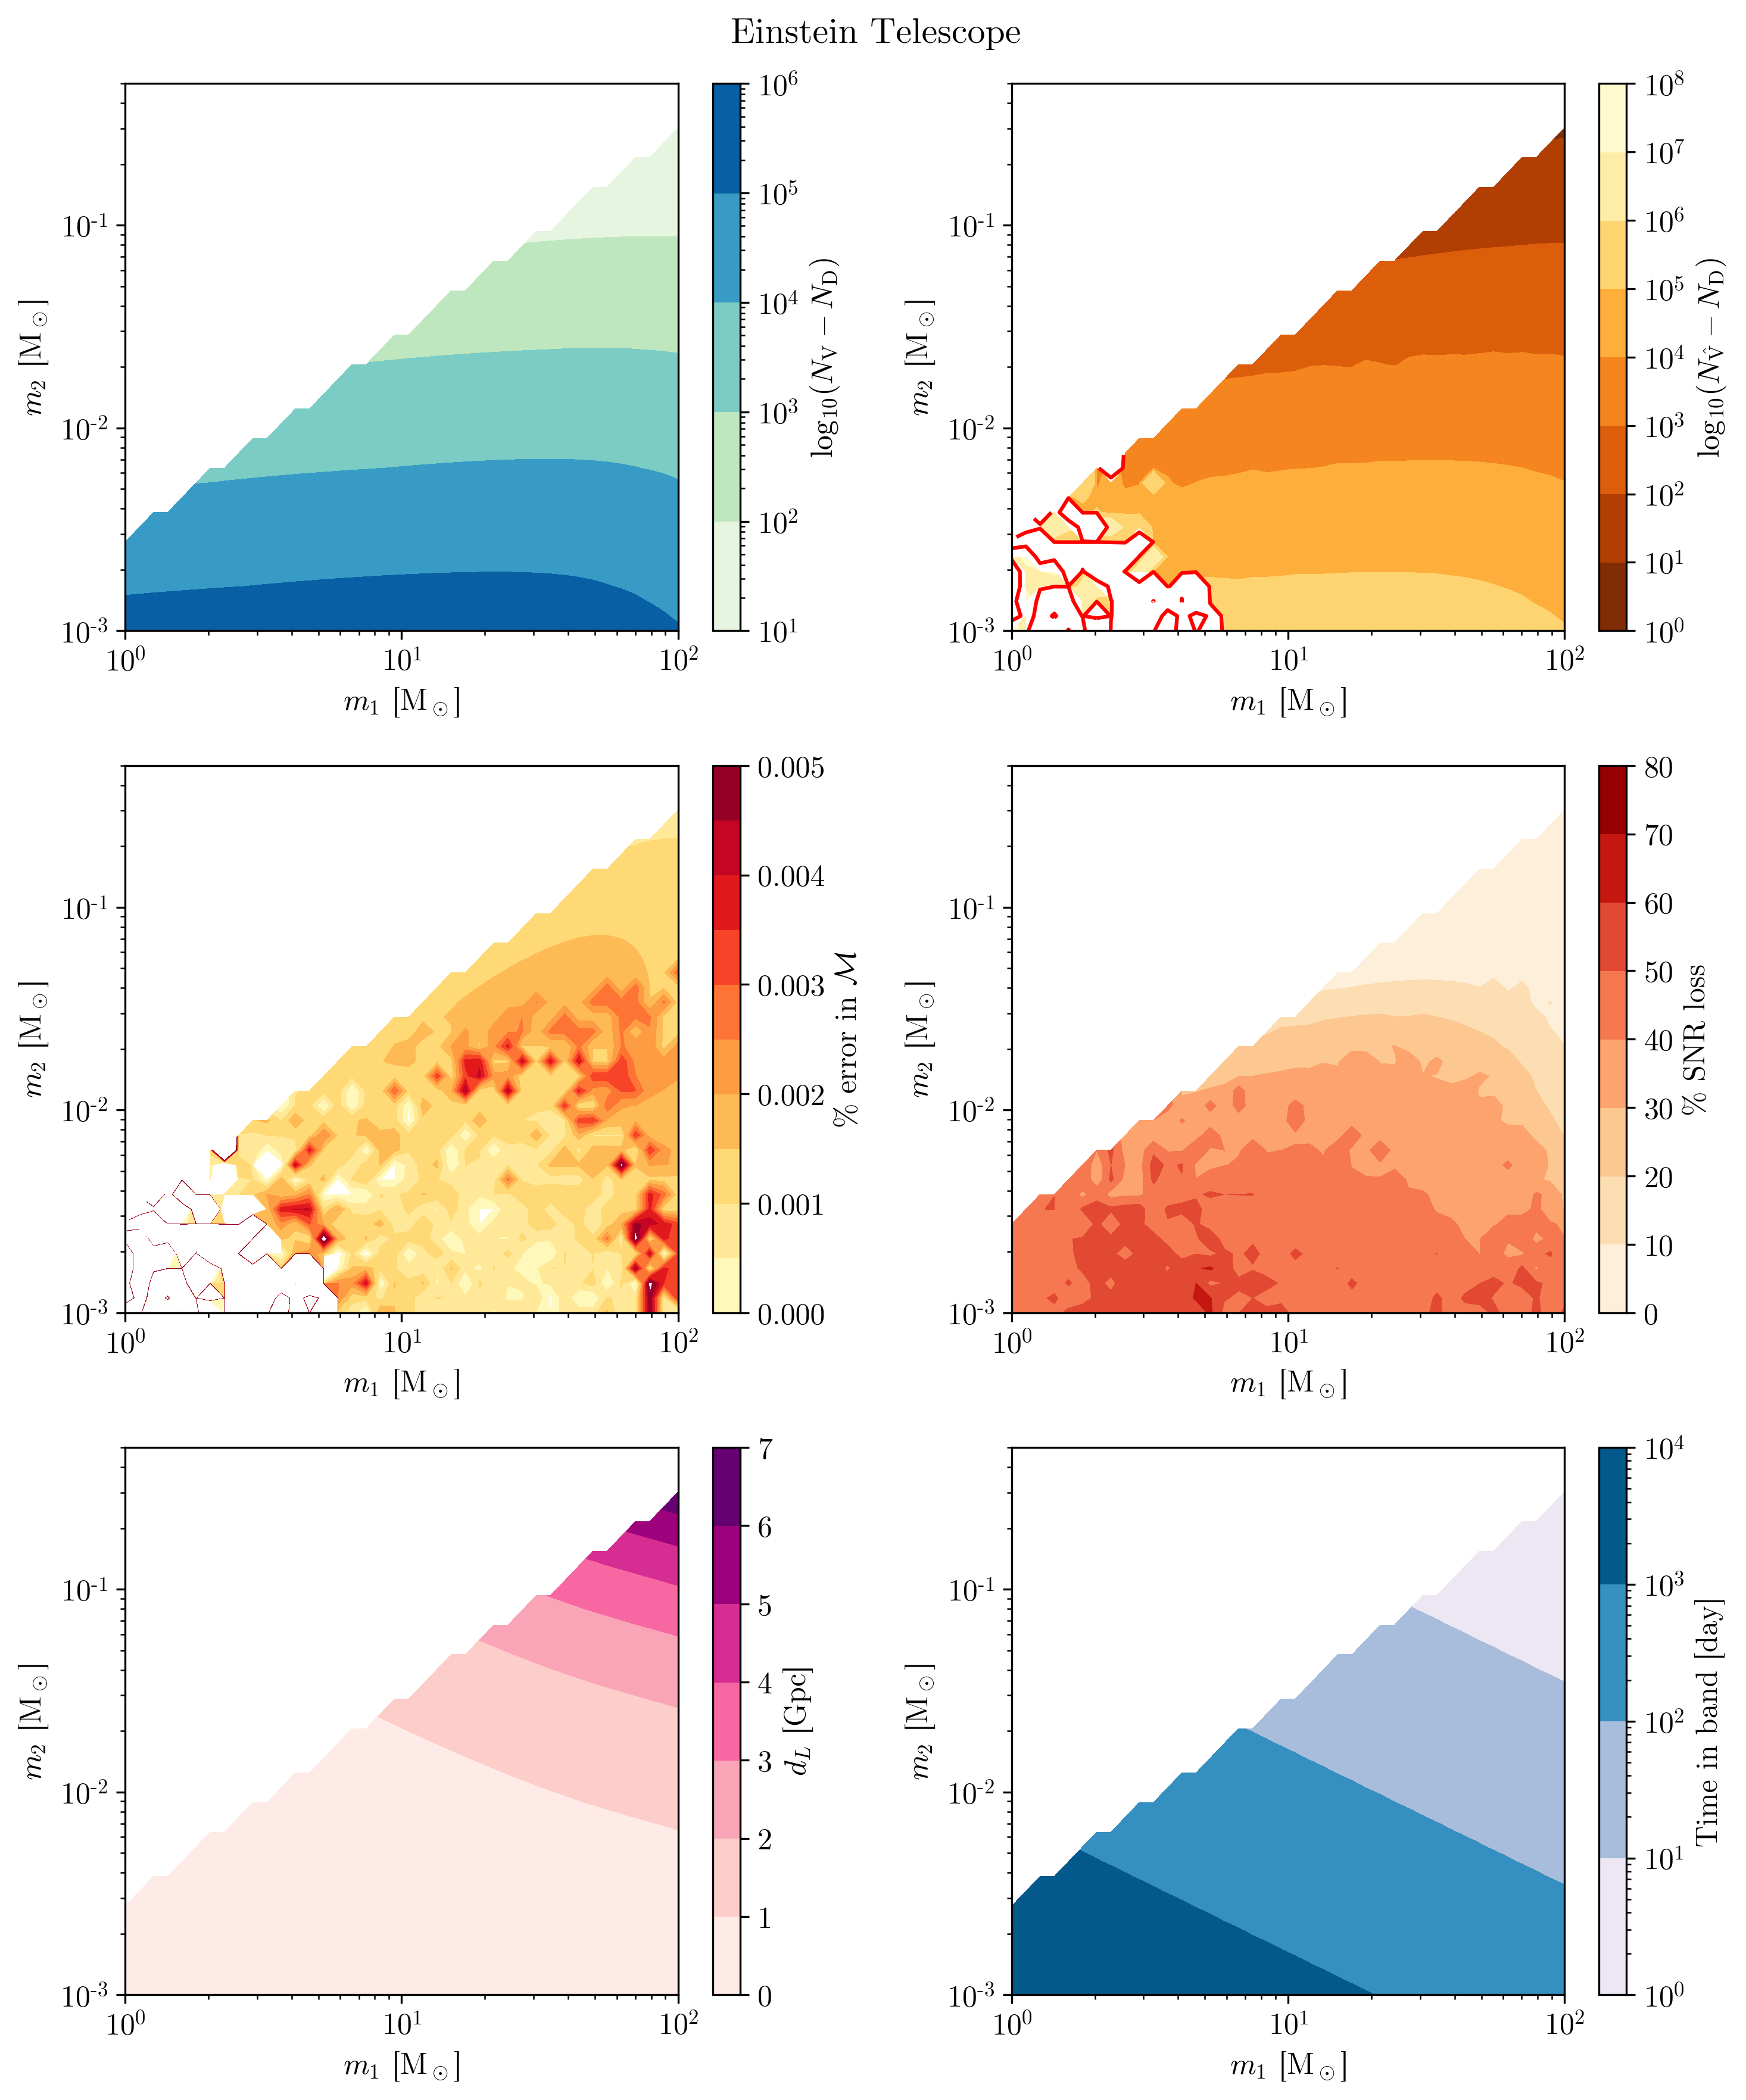

In [245]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

ax = axes[0, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN_naive"],
    locator=ticker.LogLocator(),
    cmap="GnBu",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\mathrm{V} - N_\mathrm{D})$")

ax = axes[0, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dN"],
    locator=ticker.LogLocator(),
    cmap="YlOrBr_r",
)
plt.colorbar(cs, ax=ax, label=r"$\log_{10} (N_\hat{\mathrm{V}} - N_\mathrm{D})$")
ax.contour(m_1_g / MSUN, m_2_g / MSUN, results["dN"], [1], colors=["r"])

ax = axes[1, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    (results["M_chirp_MSUN_v"] - results["M_chirp_MSUN"])
    / results["M_chirp_MSUN"]
    * 100,
    levels=jnp.linspace(0, 0.005, 11),
    cmap="YlOrRd",
)
plt.colorbar(cs, ax=ax, label=r"% error in $\mathcal{M}$")

ax = axes[1, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["snr_loss_frac"] * 100,
    levels=jnp.linspace(0, 80, 9),
    cmap="OrRd",
)
plt.colorbar(cs, ax=ax, label="% SNR loss")

ax = axes[2, 0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["dL"] / (1e9 * PC),
    levels=jnp.linspace(0, 7, 8),
    cmap="RdPu",
)
plt.colorbar(cs, ax=ax, label=r"$d_L$ [Gpc]")

ax = axes[2, 1]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["t_to_h"] / (24 * 60**2),
    cmap="PuBu",
#     levels=jnp.linspace(0, 2e3, 11),
    locator=ticker.LogLocator(),
)
plt.colorbar(cs, ax=ax, label="Time in band [day]")

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")

fig.tight_layout()
fig.suptitle(title)
# plt.savefig(plot_name)

Chirp/high frequency and break frequency

<ipython-input-69-c9cf32d082d1>:16: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(


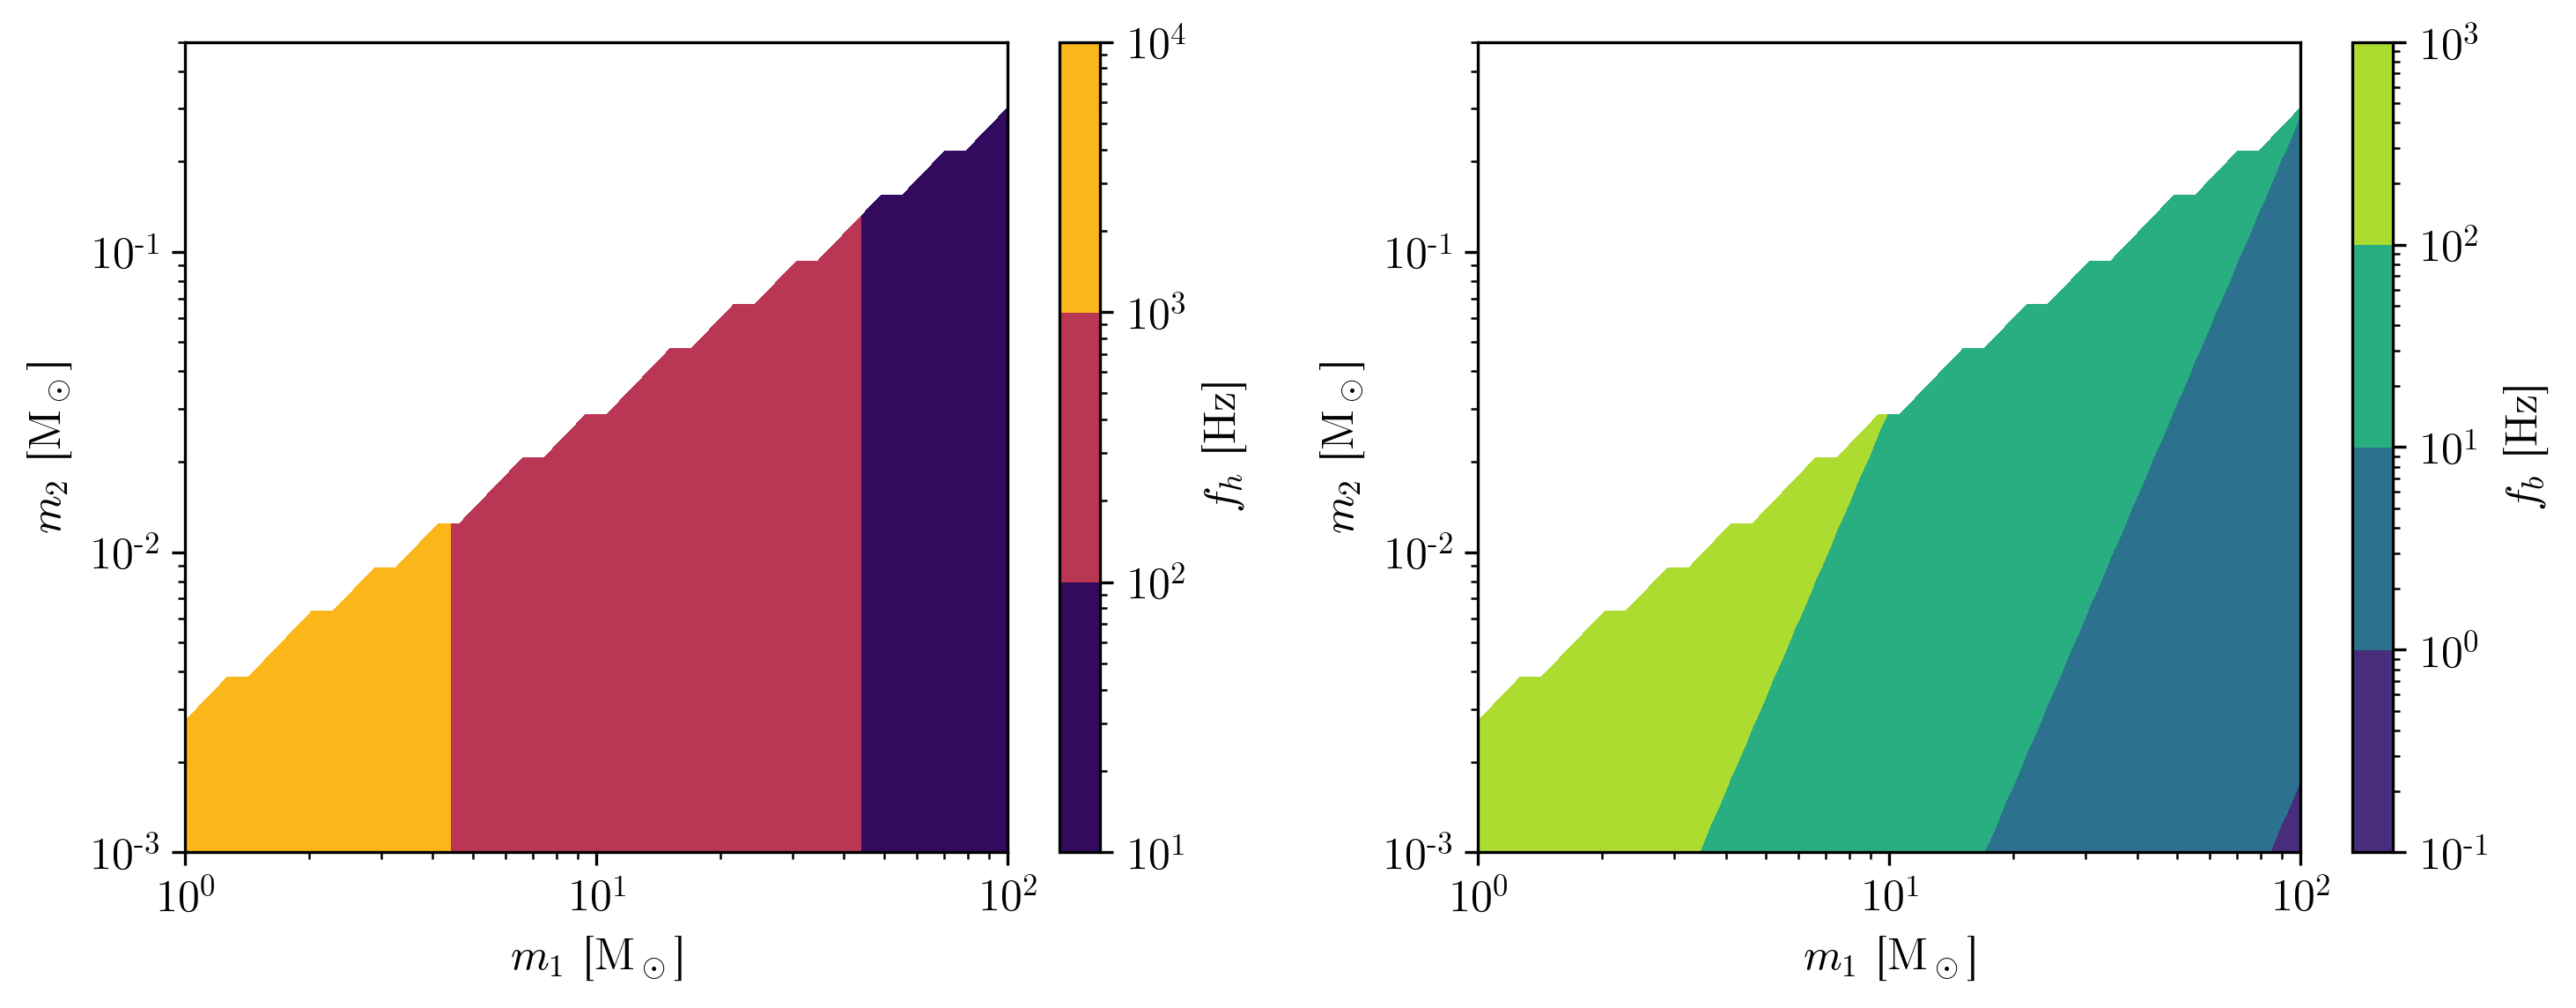

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    results["f_h"],
    locator=ticker.LogLocator(),
#     levels=jnp.geomspace(1e1, 1e4, 10),
    cmap="inferno",
)
plt.colorbar(cs, ax=ax, label=r"$f_h$ [Hz]")

ax = axes[1]
f_bs = jnp.vectorize(lambda m_1, m_2: get_f_b(m_1, m_2, gamma_s_pbh))(m_1_mg, m_2_mg)
cs = ax.contourf(
    m_1_g / MSUN,
    m_2_g / MSUN,
    f_bs * (m_2_mg / m_1_mg < 10**(-2.5)),
    locator=ticker.LogLocator(),
#     levels=jnp.geomspace(1e-1, 1e4, 11),
#     cmap="cividis",
)
plt.colorbar(cs, ax=ax, label=r"$f_b$ [Hz]")

for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_1$ [M$_\odot$]")
    ax.set_ylabel(r"$m_2$ [M$_\odot$]")

fig.tight_layout()

### Check whether fits are reliable or too unstable. They look pretty reasonable, even for quite large dephasings.

In [72]:
dd = make_dynamic_dress(40 * MSUN, 1e-2 * MSUN, rho_s_pbh, gamma_s_pbh, dL=120e6 * MSUN)


def fun(M_chirp_MSUN):
    vb = VacuumBinary(M_chirp_MSUN * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    f_h = min(dd.f_c, f_range_et[1])
    return loglikelihood_fft(vb, dd, f_range_et[0], f_h, 100000, 1000, S_n_et)

bracket = (dd.M_chirp / MSUN * (1 - 1e-5), dd.M_chirp / MSUN * (1 + 5e-5))
M_chirp_MSUNs = jnp.linspace(*bracket, 200)
lls = jnp.array([fun(Mc) for Mc in M_chirp_MSUNs])

vb = VacuumBinary(
    M_chirp_MSUNs[jnp.argmax(lls)] * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c
)
f_l, f_h = f_range_et[0], min(f_range_et[1], dd.f_c)
print(
    "dN = ",
    (Phi_to_c(f_l, vb) - Phi_to_c(f_h, vb) - (Phi_to_c(f_l, dd) - Phi_to_c(f_h, dd)))
    / (2 * pi),
)

dN =  5020.112117056262


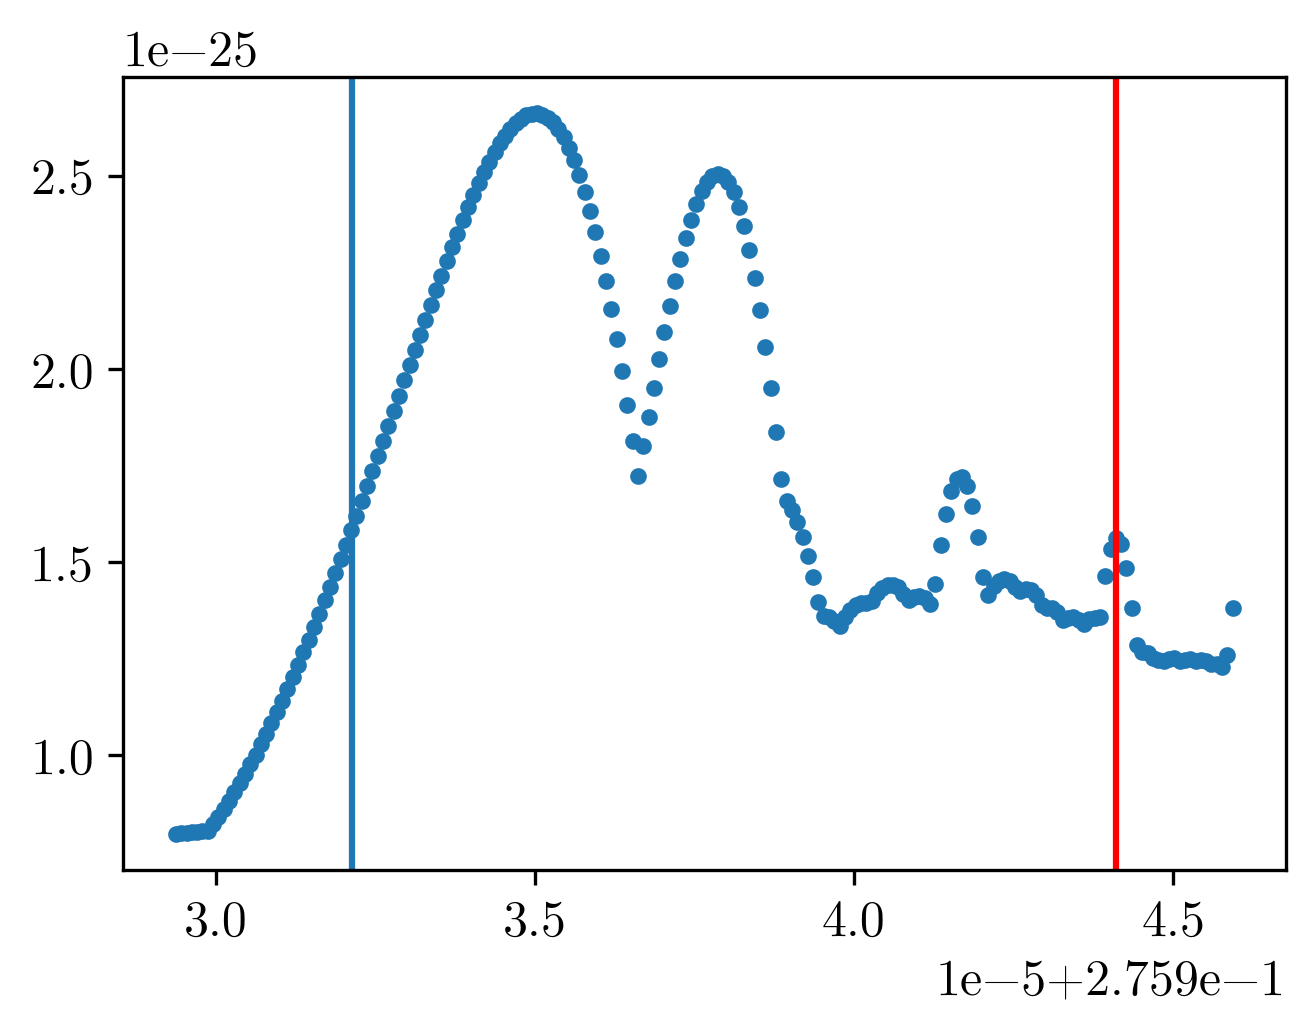

In [73]:
plt.plot(M_chirp_MSUNs, lls, ".")
plt.axvline(dd.M_chirp / MSUN)
plt.axvline(minimize_scalar(lambda x: -fun(x), bracket).x, color="r")

## Density normalization

In [105]:
def get_rho_6T(m_1, rho_s=1.798e4 * MSUN / PC ** 3):
    fun = lambda rho_6T: get_rho_s(rho_6T * 1e16 * MSUN / PC ** 3, m_1, 9 / 4) - rho_s
    return root_scalar(fun, bracket=(1e-6, 1e1)).root

Text(0.5, 1.0, 'PBH dress density normalization')

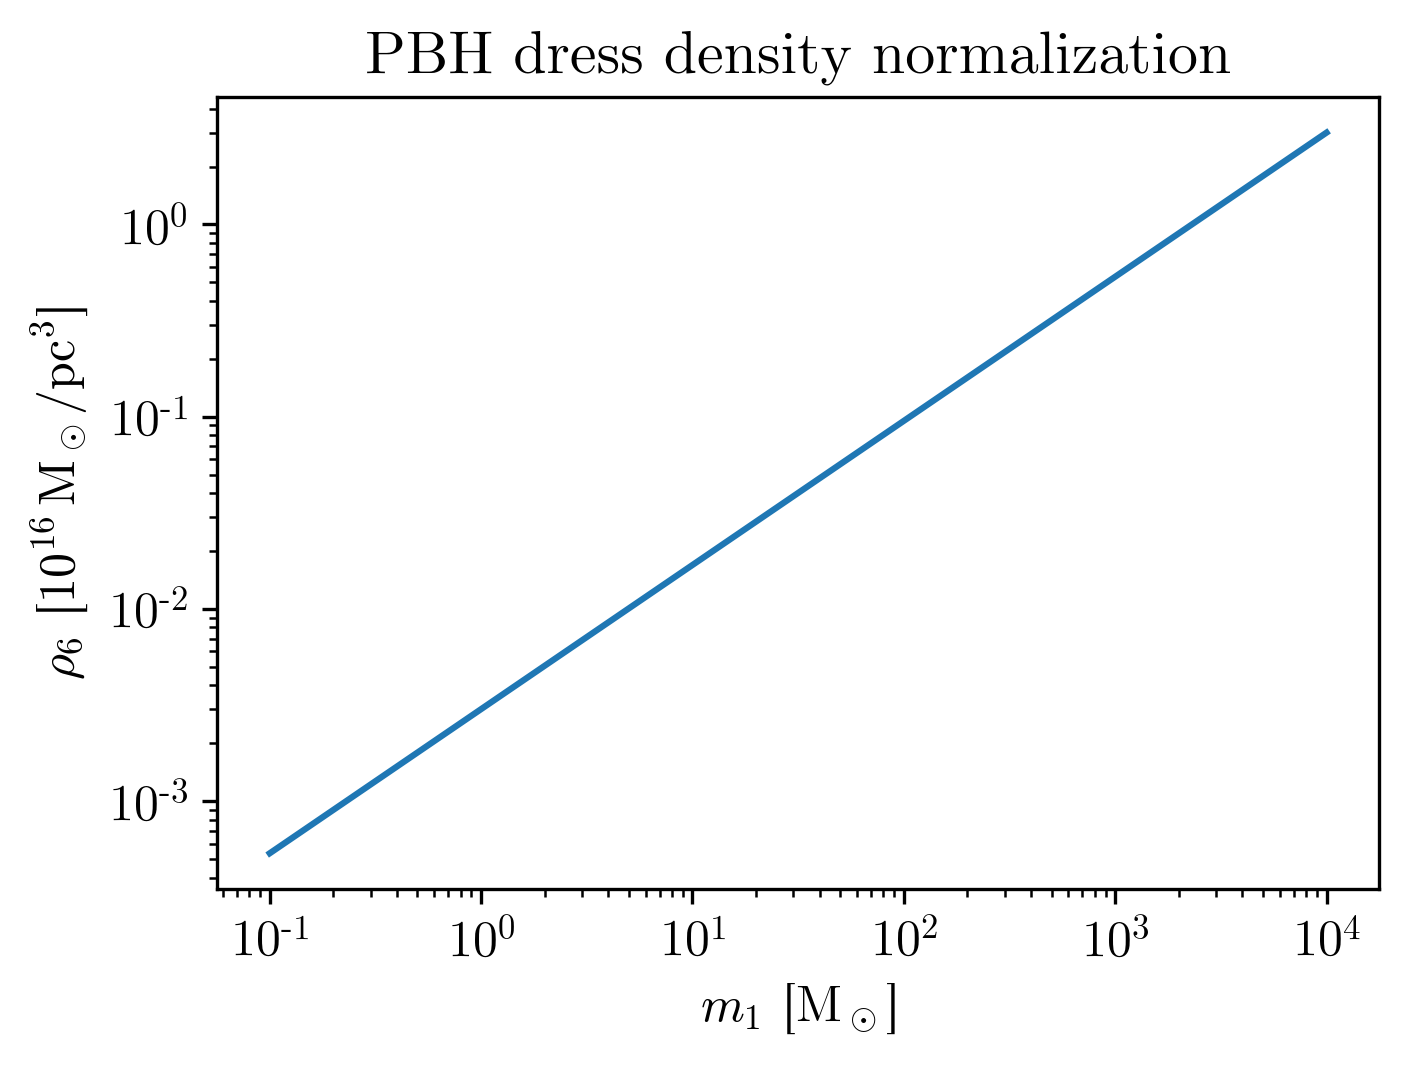

In [113]:
m_1s = jnp.geomspace(1e-1 * MSUN, 1e4 * MSUN, 100)

plt.loglog(m_1s / MSUN, list(map(get_rho_6T, m_1s)))
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$\rho_6$ [$10^{16} \, \mathrm{M}_\odot / \mathrm{pc}^3$]")
plt.title("PBH dress density normalization")

## Old

In [65]:
print("SNR = ", calculate_SNR(dd, f_l, dd.f_c, 3000, S_n))
print("dPhi (naive) = ", (Phi_to_c(f_l, vb_0) - Phi_to_c(f_l, dd)) / (2 * pi))

SNR =  14.991045811241946
Naive dephasing =  -5.229407663098171


Find best-fit vacuum system

In [14]:
dd = make_dynamic_dress(
    5 * MSUN, 5e-3 * MSUN, 1.798e4 * MSUN / PC ** 3, 9 / 4, dL=26e6 * PC
)
f_l = 20.0

In [69]:
def fun(x):
    vb = VacuumBinary(x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
    return -loglikelihood_fft(vb, dd, f_l, dd.f_c, 5000, 1000, S_n)


res = minimize_scalar(fun, bracket=(dd.M_chirp / MSUN, dd.M_chirp / MSUN + 1e-4), tol=1e-100)
assert res.success
vb = VacuumBinary(res.x * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
print("p(h|s) = ", -res.fun)
print("p(s|s) = ", loglikelihood_fft(dd, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("Dephasing = ", (Phi_to_c(f_l, vb) - Phi_to_c(f_l, dd)) / (2 * pi), " cycle")

p(h|s) =  71.7761575459551
p(s|s) =  112.47968507665817
Dephasing =  -1.215834026833111  cycle


Text(0, 0.5, 'Match integrand [s?]')

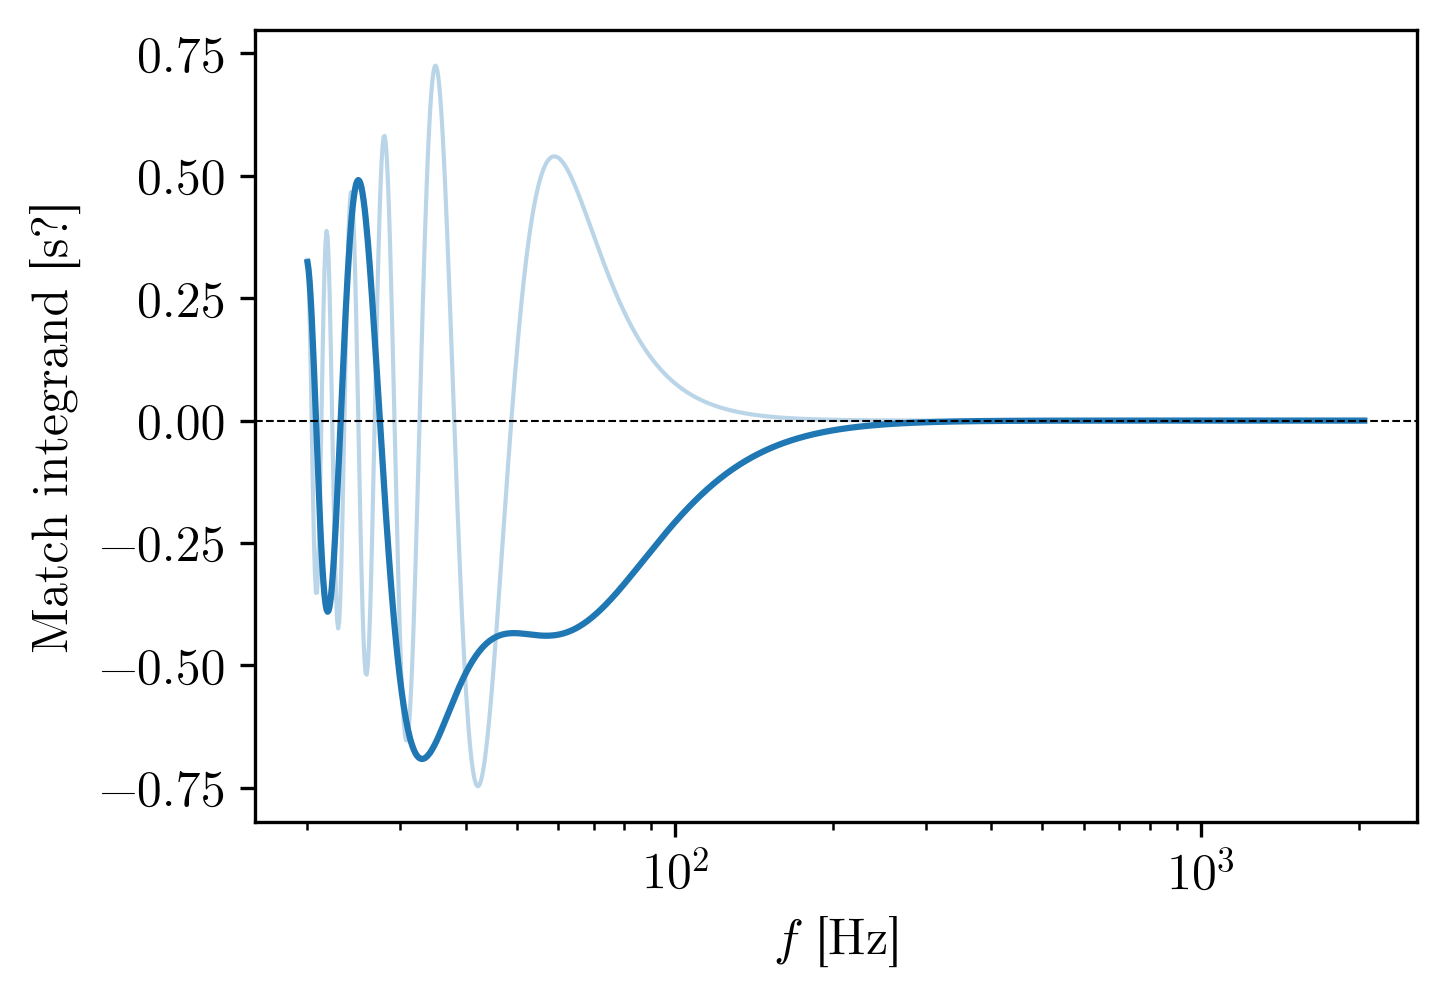

In [29]:
plt.semilogx(
    fs, amp(fs, vb) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
)
# plt.semilogx(
#     fs, amp(fs, vb) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb) - Phi_to_c(fs, dd)) / S_n(fs)
# )

plt.semilogx(
    fs,
    amp(fs, vb_0) * amp(fs, dd) * jnp.sin(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
    "C0",
    alpha=0.3,
    linewidth=1
)
# plt.semilogx(
#     fs,
#     amp(fs, vb_0) * amp(fs, dd) * jnp.cos(Phi_to_c(fs, vb_0) - Phi_to_c(fs, dd)) / S_n(fs),
#     "C1",
#     alpha=0.3,
#     linewidth=1
# )

plt.axhline(0, linestyle="--", color="k", linewidth=0.5)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Match integrand [s?]")

## Scratch

Text(0, 0.5, 'Strain')

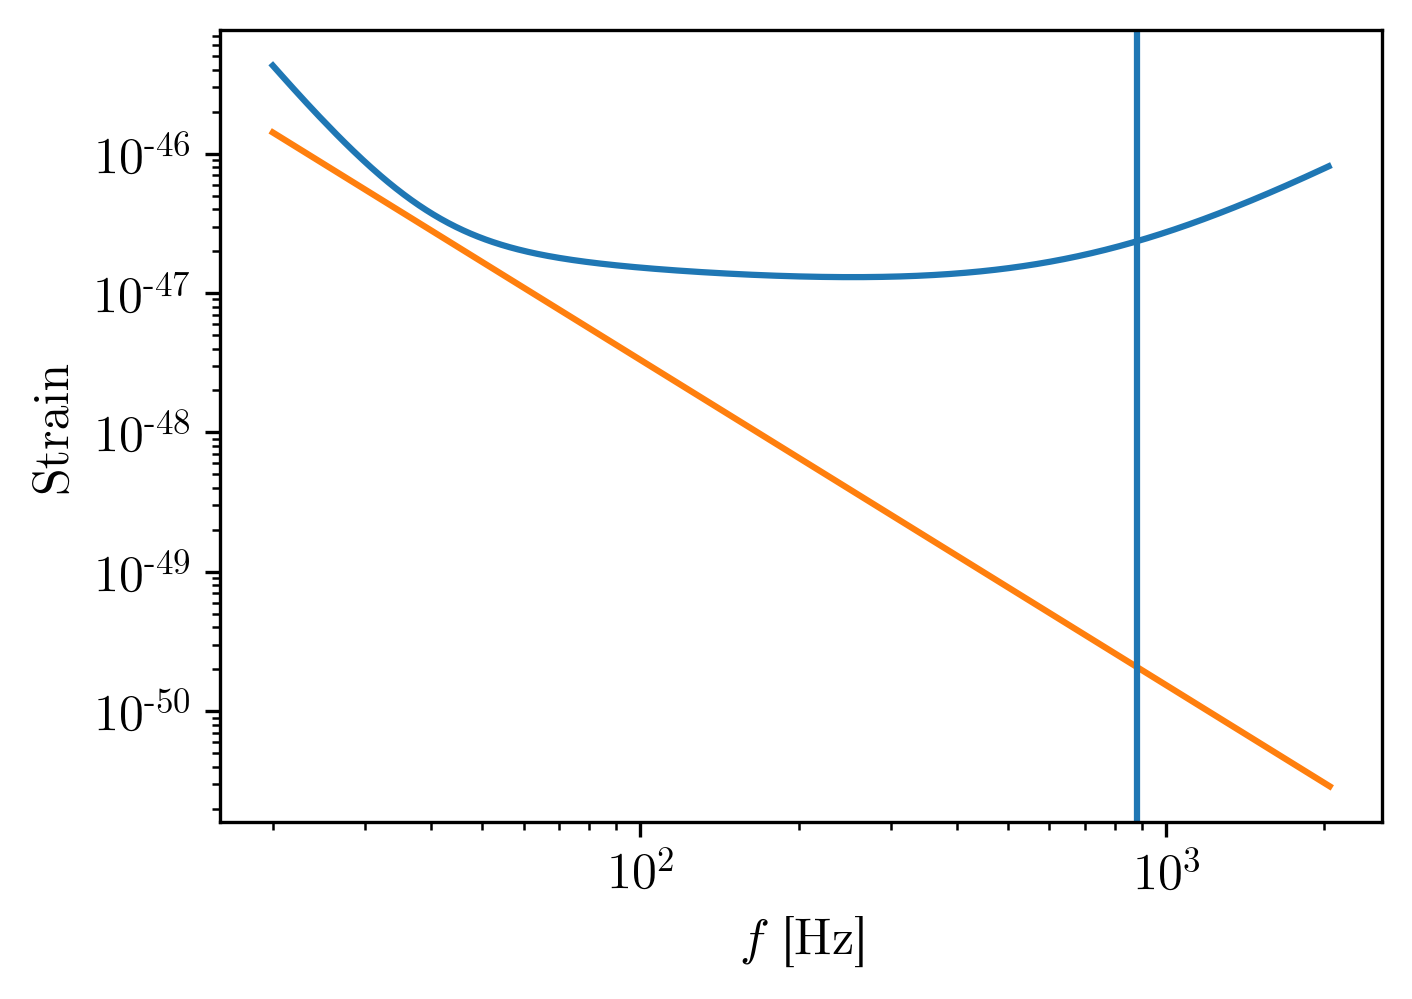

In [155]:
plt.loglog(fs, S_n(fs))
plt.loglog(fs, amp(fs, dd) ** 2)
plt.axvline(dd.f_c)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("Strain")

In [148]:
vb = VacuumBinary(0.079231 * MSUN, dd.Phi_c, dd.tT_c, dd.dL, dd.f_c)
print("p(h|s) = ", loglikelihood_fft(vb, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("p(s|s) = ", loglikelihood_fft(dd, dd, f_l, dd.f_c, 5000, 1000, S_n))
print("Dephasing = ", (Psi(f_l, vb) - Psi(f_l, dd)) / (2 * pi), " cycle")

p(h|s) =  14.498258565576357
p(s|s) =  112.47968507665817
Dephasing =  -2.995448516048727  cycle
